Part A.

 

Create a project using Python and tools in the Python ecosystem to download some data and answer some questions. Data sourcing, cleaning, and exploration is part of the project so show your work.

 

Using the 311 Service Request data from Open Data NYC (https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) answers following questions for complaints in 2017. Use other datasets as needed, for population data, for data cleaning, etc.

 

·         Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?

·         Consider only the 10 most common overall complaint types.  For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?

·         Considering all complaint types. Calculate the complaints per person that gives an indication of which boroughs make the most complaints, i.e. biggest complainers.

 

Commit the code to a git repo. In case you can't get Part B to work, at least get this repo pushed up to Github/Gitlab or the like so you can share it with us.

 

Notes/hints:

 

·         For the 311 data, programmatically source the data. Use the Socrata Open Data API https://dev.socrata.com/foundry/data.cityofnewyork.us/fhrw-4uyv.

·         For population by zip code you can use https://blog.splitwise.com/2013/09/18/the-2010-us-census-population-by-zip-code-totally-free/. You can just pretend ZCTA == zip and it's ok that it's 2010 census data although we're asking about 2017 complaint data.

·         Feel free to use other datasets if you find the need. For example, is there a way to clean up "Unspecified" Boroughs?

·         Use Python, Pandas, and Jupyter. Consider using https://hub.docker.com/r/jupyter/datascience-notebook/.

In [1]:
# Imports
import os,time,math
import pandas as pd
import numpy as np

# TODO add to pipenv
from sodapy import Socrata

In [2]:
# Socrata API resource info
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'fhrw-4uyv'

In [3]:
# init API Client, No need for API token since it's open and just a one time data extraction
client = Socrata(socrata_domain,None)
print("Domain:",client.domain)

Domain: data.cityofnewyork.us


In [4]:
# Load zipcodes file from splitwise and prep it
zip_codes_url = 'https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv'
zips = pd.read_csv(zip_codes_url,names=['zipcode','pop_2010'],skiprows=1)
zips.zipcode = zips.zipcode.astype(str)
zips.head()

,zipcode,pop_2010
0,1001,16769
1,1002,29049
2,1003,10372
3,1005,5079
4,1007,14649


In [5]:
# To Load all data for 2017 we need to know how many rows exist in there and page through them.
# Limit of 1m works after testing.
limit = loopsize = 1000*1000

# get the count of rows in filtered by the year 2017
count_result = client.get(socrata_dataset_identifier,select='count(unique_key)',where='date_extract_y(created_date)==2017')
count = int(count_result[0]['count_unique_key'])

# How many loops based on the number of rows and loopsize
loops = math.ceil(count/loopsize)
loops

3

In [200]:
# Page through the data and load it into a dataframe.
# specific coloums where selected so that the data size isn't too big to load and to make the request and the analysis more effeciant.
dfs = [] 
for i in range(0,loops):
    try:
        results = client.get(socrata_dataset_identifier,select='created_date,complaint_type,city,borough,incident_zip',
                         where='date_extract_y(created_date)==2017',limit=loopsize,offset=loopsize*i)
    except:
        print('Try To run this cell again because the operation has timed out')
    df = pd.DataFrame.from_dict(results)
    dfs.append(df)
    print( i , df.shape ,' offset =', loopsize*i)

df = pd.concat(dfs)
df.created_date = pd.to_datetime(df.created_date)
df.shape

0 (1000000, 5)  offset = 0
1 (1000000, 5)  offset = 1000000
2 (461176, 5)  offset = 2000000


(2461176, 5)

In [ ]:
# Verify that the data only belongs to the year 2017
df.created_date.dt.year.value_counts()

In [ ]:
# Combine both datasets
df = df.join(zips.set_index('zipcode'),on='incident_zip')

In [ ]:
df.head()

In [56]:
#check if there are any zip codes with no population numbers
df[df.pop_2010.isna()].incident_zip.value_counts().head()

07114    137
10000    130
10121    110
N/A      100
10281     66
Name: incident_zip, dtype: int64

In [57]:
#zipcode 11249 has high complaint type, so we manually get the population data data from 
# https://www.zipdatamaps.com/11249
df.loc[df.incident_zip == '11249','pop_2010'] = 97978
df[df.incident_zip=='11249'].head()

,borough,city,complaint_type,created_date,incident_zip,pop_2010
459,BROOKLYN,BROOKLYN,Graffiti,2017-04-10 08:05:45,11249,97978.0
520,BROOKLYN,BROOKLYN,Graffiti,2017-04-12 10:41:48,11249,97978.0
1028,BROOKLYN,BROOKLYN,Graffiti,2017-06-03 11:01:38,11249,97978.0
1035,BROOKLYN,BROOKLYN,Graffiti,2017-06-03 11:03:01,11249,97978.0
1054,BROOKLYN,BROOKLYN,Graffiti,2017-06-03 10:59:07,11249,97978.0


**1. Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?**

In [96]:
# Problem Breakdown
# - Find the top 10 complaints, breakdown the dataset by borough for these specific complaints.
top_complaints = df.complaint_type.value_counts().nlargest(10).index.values
df_top_complaints = df[df.complaint_type.isin(top_complaints)] # Filtered dataset
df_top_complaints_by_borough = df_top_complaints.borough.value_counts().to_frame()
df_top_complaints_by_borough_by_complaint = df_top_complaints.groupby(['borough','complaint_type']).size().to_frame()
df_top_complaints_by_borough_by_complaint.columns = ['# Of Compalints']

In [97]:
df_top_complaints_by_borough_by_complaint

# Of Compalints
borough       complaint_type                         
BRONX         Blocked Driveway                  23682
              HEAT/HOT WATER                   116659
              Illegal Parking                   13976
              Noise                              2681
              Noise - Residential               58608
              PAINT/PLASTER                     20804
              Street Condition                  13922
              Street Light Condition            17962
              UNSANITARY CONDITION              24612
              Water System                       7805
BROOKLYN      Blocked Driveway                  47280
              HEAT/HOT WATER                   107480
              Illegal Parking                   50707
              Noise                             13956
              Noise - Residential               57494
              PAINT/PLASTER                     20511
              Street Condition                  27068
              Street Light Condition            23589
              UNSANITARY CONDITION              25049
              Water System                      21474
MANHATTAN     Blocked Driveway                   2926
              HEAT/HOT WATER                    69151
              Illegal Parking                   16765
              Noise                             30254
              Noise - Residential               52728
              PAINT/PLASTER                     12450
              Street Condition                  16799
              Street Light Condition            11222
              UNSANITARY CONDITION              13565
              Water System                       9897
QUEENS        Blocked Driveway                  51954
              HEAT/HOT WATER                    46432
              Illegal Parking                   42255
              Noise                              9508
              Noise - Residential               35128
              PAINT/PLASTER                      5740
              Street Condition                  33594
              Street Light Condition            25558
              UNSANITARY CONDITION              11111
              Water System                      17355
STATEN ISLAND Blocked Driveway                   3290
              HEAT/HOT WATER                     2962
              Illegal Parking                    6820
              Noise                              1640
              Noise - Residential                5479
              PAINT/PLASTER                       976
              Street Condition                  12273
              Street Light Condition             7062
              UNSANITARY CONDITION               1693
              Water System                       5282
Unspecified   Blocked Driveway                   1410
              Illegal Parking                    1756
              Noise                                 3
              Noise - Residential                 918
              Street Condition                     57
              Street Light Condition             1390

In [98]:
df_top_complaints_by_borough

,borough
BROOKLYN,394608
BRONX,300711
QUEENS,278635
MANHATTAN,235757
STATEN ISLAND,47477
Unspecified,5534


**2. Consider only the 10 most common overall complaint types. For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?**

Problem Breakdown
- Top 10 Complaints
- Get the top ten zipcodes by population
- Filter the dataset for those zipcode and top ten complaints
- break it down by complaint type

In [101]:
# Since the zipcodes are for all the US we only get 4 results so we need a different approach
df[df.incident_zip.isin(zips.nlargest(10,'pop_2010').zipcode.values)].incident_zip.value_counts()

11226    45492
11373    20214
11368    19954
11220    19707
Name: incident_zip, dtype: int64

In [116]:
# Ge the top zips by population.
top_zips = df.incident_zip.value_counts().nlargest(10).index.values
# 
df_top_complaints_top_zips = df_top_complaints[df_top_complaints.incident_zip.isin(top_zips)]
df_top_complaints_top_zips.incident_zip.value_counts().to_frame()
df_top_complaints_top_zips.groupby(['incident_zip','complaint_type']).size().to_frame()

0
incident_zip complaint_type               
10452        Blocked Driveway         1048
             HEAT/HOT WATER           8631
             Illegal Parking           477
             Noise                     130
             Noise - Residential      4102
             PAINT/PLASTER            1548
             Street Condition          390
             Street Light Condition    271
             UNSANITARY CONDITION     1808
             Water System              374
10453        Blocked Driveway         1492
             HEAT/HOT WATER          10455
             Illegal Parking           653
             Noise                     105
             Noise - Residential      3551
             PAINT/PLASTER            2156
             Street Condition          517
             Street Light Condition    191
             UNSANITARY CONDITION     2092
             Water System              437
10456        Blocked Driveway         1172
             HEAT/HOT WATER           7069
             Illegal Parking           478
             Noise                      67
             Noise - Residential      4091
             PAINT/PLASTER            1609
             Street Condition          373
             Street Light Condition    161
             UNSANITARY CONDITION     1725
             Water System              360
...                                    ...
11207        Blocked Driveway         1854
             HEAT/HOT WATER           3793
             Illegal Parking          1373
             Noise                     186
             Noise - Residential      2331
             PAINT/PLASTER            1162
             Street Condition         1187
             Street Light Condition    974
             UNSANITARY CONDITION     1483
             Water System              489
11226        Blocked Driveway         2121
             HEAT/HOT WATER          12541
             Illegal Parking           839
             Noise                     451
             Noise - Residential      4447
             PAINT/PLASTER            2914
             Street Condition          555
             Street Light Condition    218
             UNSANITARY CONDITION     2981
             Water System              414
11385        Blocked Driveway         3045
             HEAT/HOT WATER           2348
             Illegal Parking          4174
             Noise                     462
             Noise - Residential      2111
             PAINT/PLASTER             369
             Street Condition         1301
             Street Light Condition    795
             UNSANITARY CONDITION      636
             Water System             1016

[100 rows x 1 columns]

In [178]:
top_10_populated_zips = zips[zips.zipcode.isin(df.incident_zip.unique())]
top_10_populated_zips.pop_2010.nlargest(10)
df.groupby(['incident_zip','pop_2010']).size().head(370)

incident_zip  pop_2010
10001         21102.0     10251
10002         81410.0     20500
10003         56024.0     18372
10004         3089.0       1807
10005         7135.0       1826
10006         3011.0        827
10007         6988.0       3457
10009         61347.0     15907
10010         31834.0      7553
10011         50984.0     13887
10012         24090.0     10035
10013         27700.0     10178
10014         31959.0     10219
10016         54183.0     15817
10017         16575.0      6169
10018         5229.0       5053
10019         42870.0     16236
10020         0.0           238
10021         43631.0      9000
10022         31924.0      8901
10023         60998.0     11848
10024         59283.0     12562
10025         94600.0     20553
10026         34003.0     10786
10027         59707.0     17442
10028         45141.0      7934
10029         76003.0     17886
10030         26999.0     10508
10031         56438.0     25689
10032         57331.0     20255
                 

In [198]:
df_top_complaints = df_top_complaints.fillna({'incident_zip':'none'})
df_clean_zips = df_top_complaints[df_top_complaints.incident_zip.str.startswith('10') | 
                  df_top_complaints.incident_zip.str.startswith('11')].sort_values('pop_2010',ascending=False)

df_clean_zips.



,borough,city,complaint_type,created_date,incident_zip,pop_2010
386578,QUEENS,CORONA,Blocked Driveway,2017-03-01 21:59:39,11368,109931.0
561673,QUEENS,CORONA,Blocked Driveway,2017-01-11 19:38:14,11368,109931.0
496887,QUEENS,CORONA,Illegal Parking,2017-03-19 19:07:55,11368,109931.0
192322,QUEENS,CORONA,Illegal Parking,2017-01-26 19:33:40,11368,109931.0
531161,QUEENS,Corona,HEAT/HOT WATER,2017-01-07 11:21:51,11368,109931.0
268360,QUEENS,Corona,Noise,2017-02-08 23:53:00,11368,109931.0
774126,QUEENS,CORONA,Blocked Driveway,2017-05-05 18:43:30,11368,109931.0
873927,QUEENS,CORONA,Noise - Residential,2017-05-21 04:08:14,11368,109931.0
774138,QUEENS,CORONA,Blocked Driveway,2017-05-06 00:33:41,11368,109931.0
176959,QUEENS,Corona,HEAT/HOT WATER,2017-02-06 20:22:45,11368,109931.0


In [165]:
df.incident_zip.dropna()

0         11428
1         11355
2         11691
3         11368
4         11368
5         11368
6         11694
7         11434
8         11435
9         11355
10        11412
11        11434
12        10011
13        11423
14        11435
15        11419
16        11694
17        11378
18        11104
19        11355
20        11416
21        11427
22        11694
23        10010
24        11378
25        11420
26        10013
27        11368
28        11434
29        11412
          ...  
461143    11105
461144    10040
461145    10452
461146    10459
461147    11212
461148    10040
461149    11432
461150    11237
461151    10028
461152    10034
461153    10014
461154    11369
461155    11228
461156    11212
461157    11206
461158    11201
461159    10025
461160    11249
461161    10029
461162    11420
461163    10465
461164    10305
461165    10468
461166    10016
461167    11368
461168    10461
461169    10469
461170    10462
461171    11229
461172    10462
Name: incident_zip, Leng

In [140]:
df.incident_zip.unique()

array(['11428', '11355', '11691', '11368', '11694', '11434', '11435',
       '11412', '10011', '11423', '11419', '11378', '11104', '11416',
       '11427', '10010', '11420', '10013', '11234', '11212', '11373',
       '11370', '11432', '11364', '11207', '10308', '11214', '11365',
       '10467', '10009', '11215', '11421', '11237', '11106', '11220',
       '11377', '11413', '11221', '10019', '11374', '11231', '10462',
       '11211', '11213', '10002', '10453', '10014', '10065', '10033',
       '11101', '11238', '10312', '11218', '11204', '10458', '11418',
       '10026', '10003', '11222', '10034', '11236', '11229', '10036',
       '11362', '10012', '10461', '11216', '11203', '10025', '11217',
       '10018', '11206', '11429', '11230', '10310', '11385', '11209',
       '11417', '10459', '10455', '11105', '11205', '11226', '10468',
       '11223', '11433', '10463', '11235', '11103', '11411', '10030',
       '10307', '10464', '11232', '10456', '10454', '11233', '10021',
       '11366', '100

In [68]:
df.incident_zip.value_counts().head(10).index.values

array(['11226', '11385', '11207', '11208', '10467', '11221', '10452',
       '11234', '10453', '11209'], dtype=object)

In [69]:
df.incident_zip.isin(zips.nlargest(10,'pop_2010').zipcode.values).value_counts()

False    286597
True      13403
Name: incident_zip, dtype: int64

**3- Considering all complaint types. Calculate the complaints per person that gives an indication of which boroughs makes the most complaints, i.e. biggest complainers.**

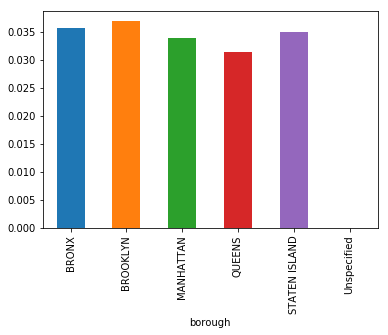

In [145]:
#How many people in each Borough

df_by_borough_zip = df.groupby(['borough','incident_zip'])
df_by_borough = df.groupby(['borough'])


population_zip_borough = df_by_borough_zip.first()

population_per_borough = population_zip_borough.groupby('borough').pop_2010.sum()

#complainers by borough

complaints_per_borough = df_by_borough.complaint_type.count()

complaints_per_person = complaints_per_borough/population_per_borough
display(complaints_per_person.plot.bar())